In [899]:
############################ 0. PREPARATION ############################

#-------------------------- import packages --------------------------
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations
import seaborn as sns
import copy
import itertools

import tensorflow as tf
import tensorflow_lattice as tfl
import tf_keras as keras # need keras 2 to fit Lattice model
from tf_keras.models import Sequential, Model
from tf_keras.layers import Dense, Input, Multiply, Add, Embedding, Reshape, Concatenate, Dropout, BatchNormalization, Lambda, Layer, CategoryEncoding, Activation
from tf_keras.constraints import Constraint
from tf_keras.callbacks import EarlyStopping
from tf_keras.initializers import Zeros, Constant
from tf_keras.optimizers import Adam, Nadam, RMSprop
from tf_keras.models import clone_model
import keras_tuner as kt
from tf_keras import backend as K
from tf_keras import regularizers
from tf_keras.utils import plot_model
from tf_keras.losses import Poisson, Loss
from tf_keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from scipy.stats import gamma


from pygam import LinearGAM, GAM, s, f, l
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
from sklearn.tree import DecisionTreeRegressor
from interpret.glassbox import ExplainableBoostingClassifier

In [900]:
#-------------------------- for reproducibility --------------------------
seed_value = 0
keras.utils.set_random_seed(seed_value)

In [901]:
#-------------------------- import data --------------------------
data = pd.read_csv("synthetic_low_var.csv")

In [902]:
#-------------------------- remove outliers --------------------------
log_claim = np.log(data['Y'])
IQR = log_claim.quantile(0.75) - log_claim.quantile(0.25) # inter-quartile range
lower_whisker = log_claim.quantile(0.25)- 1.5*IQR
upper_whisker = log_claim.quantile(0.75) + 1.5*IQR

# remove outliers: filter rows where the log of 'Y' is within the whiskers
dt_cleaned = data[(log_claim >= lower_whisker) & (log_claim <= upper_whisker)]
dt_cleaned

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,0.097627,-0.215654,-0.261487,1,-0.174621,-0.793202,5,-0.373985,0.790363,0.014048,146.926186
1,0.430379,-0.917687,-0.577348,2,0.878463,-0.924689,5,-0.133907,0.381623,-0.808513,796.680823
2,0.205527,0.846601,-0.046190,1,-0.309264,-0.659747,4,0.196131,0.513124,0.212212,594.700205
3,0.089766,-0.187530,-0.835531,0,-0.931951,0.781547,1,-0.763961,0.067880,-0.162218,59.082949
4,-0.152690,0.888564,-0.524681,1,0.045908,-0.395223,6,-0.910878,-0.748679,-0.801435,56.035251
...,...,...,...,...,...,...,...,...,...,...,...
19995,0.496349,0.336766,0.766494,0,-0.906239,0.044427,4,0.539039,0.823778,0.218616,144.414889
19996,-0.403467,0.989823,-0.239838,0,-0.264332,-0.555279,1,-0.841188,-0.964766,-0.498512,280.718125
19997,-0.107088,0.176448,-0.661992,0,0.900670,0.995538,2,0.667651,-0.428700,0.324157,983.658709
19998,-0.279747,-0.150770,-0.472139,1,0.639225,0.127594,3,0.545812,0.189384,-0.602032,624.119739


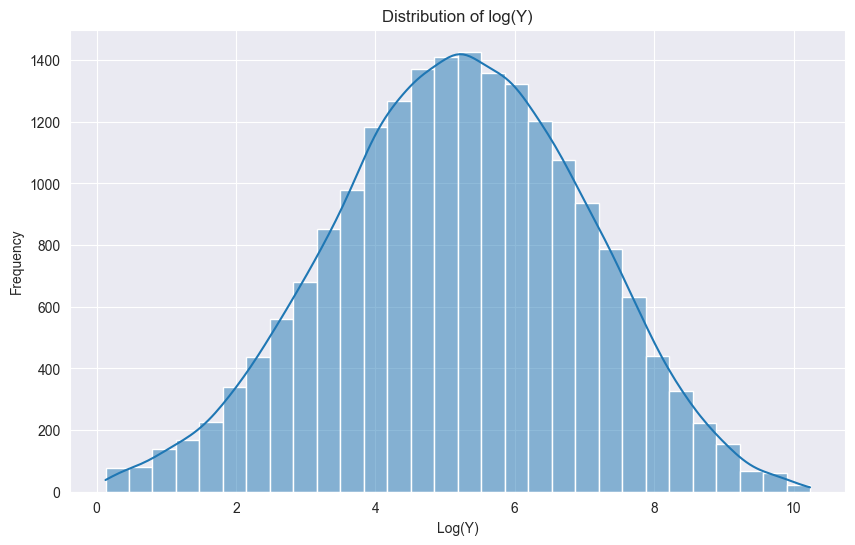

In [903]:
#-------------------------- distribution of log(response) --------------------------
plt.figure(figsize = (10, 6)) # set the size of the figure
sns.set_style("darkgrid")
sns.histplot(np.log(dt_cleaned['Y']), bins = 30, kde = True) # draw the chart
plt.title('Distribution of log(Y)')
plt.xlabel('Log(Y)')
plt.ylabel('Frequency')
plt.tick_params(axis = 'x')
plt.tick_params(axis = 'y')
plt.grid(True)
plt.show()

In [904]:
#-------------------------- column lists --------------------------
target_var = "Y" # target feature
all_vars = list(dt_cleaned.columns)
all_vars.remove(target_var) # store all input features
cat_vars = ["X4", "X7"] # categorical features
smooth_vars = ["X2","X3","X5","X6"]

In [905]:
############################ 1. MODEL FITTING ############################

#-------------------------- train-test split --------------------------
X_main, X_test, y_main, y_test = train_test_split(
    dt_cleaned[all_vars], dt_cleaned[["Y"]], test_size = 0.2, random_state = 1)
X_train, X_val, y_train, y_val  = train_test_split(
    X_main, y_main, test_size = 0.25, random_state = 1)

In [906]:
# -------------------------- function to create a subnetwork --------------------------
# Layer to center a subnetwork's outputs to zero mean
@keras.saving.register_keras_serializable()
class ZeroCenter(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def call(self, inputs):
        mean = K.mean(inputs, axis = 0, keepdims = True)
        return inputs - mean

# subnet for numerical variables
def create_subnet(num_layers, units_per_layer, activation, model_name, dropout_rate = 0, trainable = True, seed = 1):
    model = Sequential(name = model_name)
    for _ in range(num_layers):
        model.add(Dense(units_per_layer, activation = activation, trainable = trainable))
        model.add(Dropout(dropout_rate, seed = seed))
    model.add(Dense(1, trainable = trainable))
    # model.add(ZeroCenter()) # zero center all output
    return model

# layer to add all subnets' outputs and a bias term
@keras.saving.register_keras_serializable()
class AddSubnetOutput(Layer):
    def __init__(self, activation = None, **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.bias = self.add_weight(
            shape=(1,), initializer = 'zeros', trainable = True, name = 'bias'
        )
    
    def call(self, inputs):
        subnet_sum = K.sum(inputs, axis = -1, keepdims = True)
        output = subnet_sum + self.bias
        if self.activation is not None:
            output = self.activation(output)
        return output

In [907]:
# -------------------------- define model architecture --------------------------
inputs = []  # input layers
sub_outputs_main = []  # main effect subnet output
num_neurons_main = 10
num_layers_main = 2
activation = 'tanh'
keypoints = 10
monotonicity_list = {"X1" : "decreasing"} # either "increasing", "decreasing", or "none"
# lattice_smooth_reg = (0,0) # L1-L2 regularization for smoothness constraint

# main effect
for name in all_vars:
    input_layer = Input(shape = (1,), name = name)
    inputs.append(input_layer)

    # subnetworks for main effects
    if name in cat_vars: # categorical variables
        # categorical variables will be one-hot encoded
        embed_layer = Embedding(input_dim = X_train[name].nunique(), 
                                output_dim = 1, 
                                name = f"{name}_embed")(input_layer)
        embed_layer_reshape = Reshape(target_shape = (1,), name = f"{name}_reshape")(embed_layer)
        # mean_layer = ZeroCenter(name = f"{name}_mean")(embed_layer_reshape)
        switcher_layer = Dense(1, use_bias = False, 
                                kernel_initializer = Constant(1),
                                trainable = False, 
                                name = f"{name}_switcher_layer")(embed_layer_reshape)
        sub_outputs_main.append(switcher_layer)
    elif name in monotonicity_list: # variables with monotonicity constraint
        calibrator_layer = tfl.layers.PWLCalibration(
            input_keypoints =  np.linspace(X_train[name].min(), X_train[name].max(), num = keypoints), # keypoints
            # kernel_regularizer = ('hessian', lattice_smooth_reg[0], lattice_smooth_reg[1]), # for smoothness
            monotonicity = monotonicity_list[name], # monotonicity constraint
            name = f"{name}_pwlcalibrator"
        )(input_layer)
        # mean_layer = ZeroCenter(name = f"{name}_mean")(calibrator_layer)
        switcher_layer = Dense(1, use_bias = False, 
                        kernel_initializer = Constant(1),
                        trainable = False, 
                        name = f"{name}_switcher_layer")(calibrator_layer)
        sub_outputs_main.append(switcher_layer)
    else: # numeric variables
        subnet = create_subnet(num_layers_main, num_neurons_main, activation, f"{name}_subnetwork")
        sub_output = subnet(input_layer)
        switcher_layer = Dense(1, use_bias = False, 
                                kernel_initializer = Constant(1),
                                trainable = False, 
                                name = f"{name}_switcher_layer")(sub_output)
        sub_outputs_main.append(switcher_layer)

# combine subnets' outputs
main_subnets = Concatenate(name = "main_subnet")(sub_outputs_main)
final_output = AddSubnetOutput(activation = 'exponential',
                     name = "main_output")(main_subnets)

# final model
model_main_effect = Model(inputs = inputs, outputs = final_output)

python(3722) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3723) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


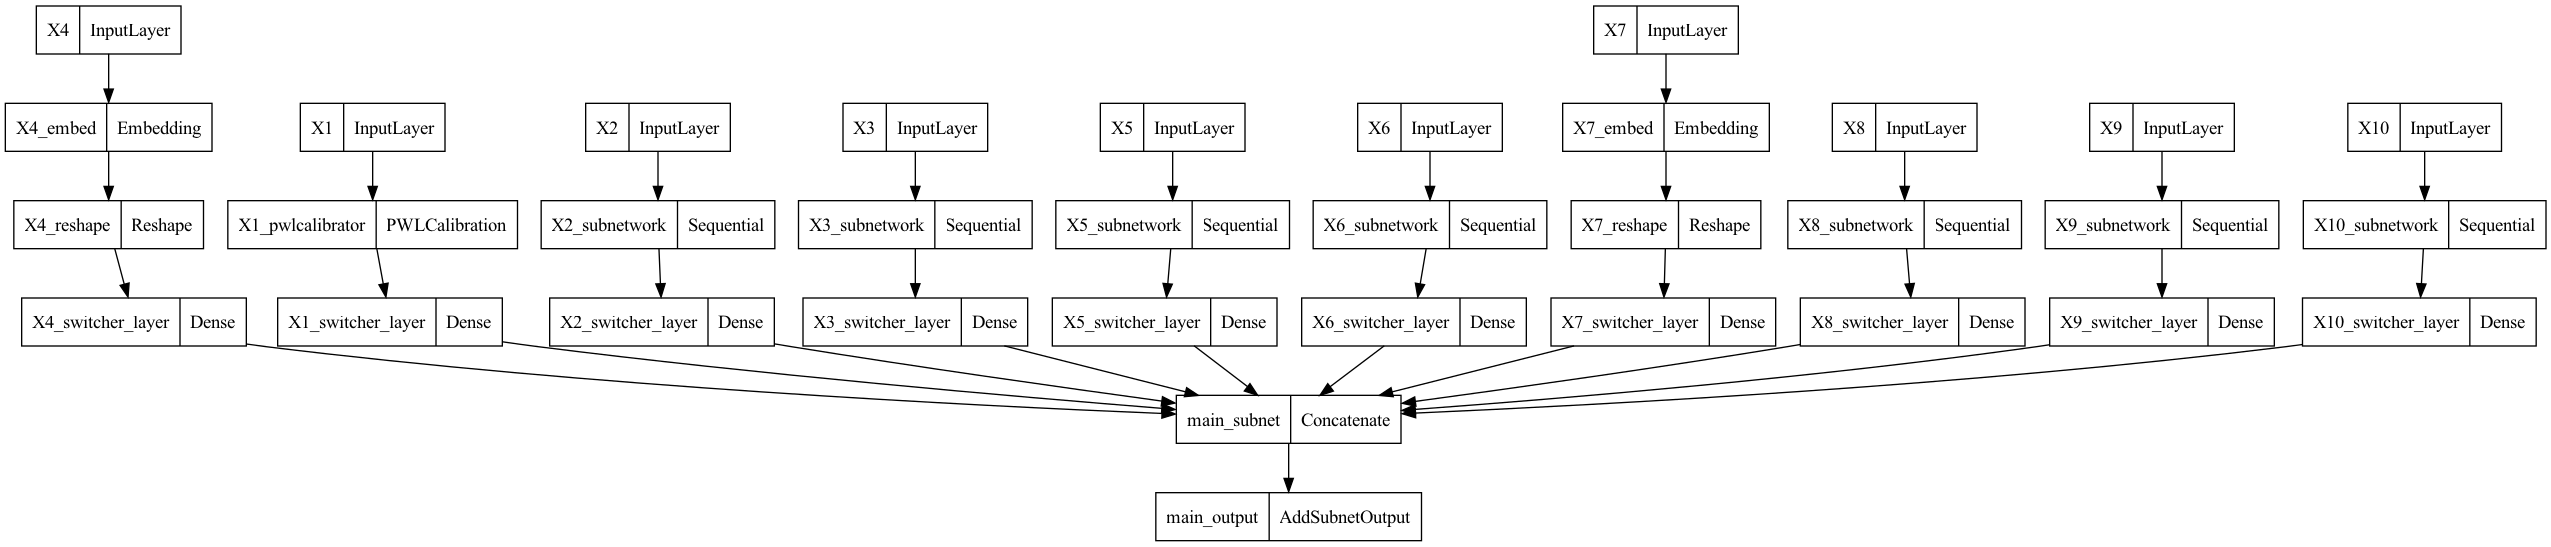

In [908]:
plot_model(model_main_effect)

In [909]:
# -------------------------- define loss function --------------------------
# # we will use a Gamma loss function
# def gamma_log_likelihood(y_true, y_pred):
#     y_pred = K.clip(y_pred, 1e-7, 1e30)
#     return K.mean(y_true/y_pred - K.log(y_true/y_pred))

# we will use a Gamma loss function
def gamma_ll_penalized(y_true, y_pred, model, X_train, smooth_vars = None, grid_points = 10000, lambd = 0):
    # get the prediction
    y_pred = K.clip(y_pred, 1e-7, 1e30)

    # initialize the loss function
    loss = K.mean(y_true/y_pred - K.log(y_true/y_pred))

    # add smoothness penalty if required
    if smooth_vars is not None:
        smooth_penalty = 0
        for var in smooth_vars:
            
            # generate grid of inputs
            min_val = X_train[var].min()
            max_val = X_train[var].max()
            grid = tf.linspace(min_val, max_val, grid_points)
            grid_input = tf.reshape(grid, (-1,1))

            # use GradientTape to calculate the second derivative
            with tf.GradientTape(persistent = True) as tape2: # for second derivative
                tape2.watch(grid_input)
                with tf.GradientTape(persistent = True) as tape1: # for first derivative
                    tape1.watch(grid_input)
                    subnetwork_output = model.get_layer(f"{var}_subnetwork")(grid_input)
                first_derivative = tape1.gradient(subnetwork_output, grid_input)  # Compute first derivative
            second_derivative = tape2.gradient(first_derivative, grid_input)  # Compute second derivative

            # add to the smoothness penalty
            smooth_penalty += K.sum(K.abs(second_derivative))
        
        # tf.print(smooth_penalty)
        # ensure smooth_penalty is of the same dtype as loss and then sum them up
        smooth_penalty = K.cast(smooth_penalty, dtype = tf.float32)
        lambd = K.cast(lambd, dtype = tf.float32)
        loss += lambd*smooth_penalty

    return loss

In [910]:
# -------------------------- fit the model --------------------------
# create training & validation data consistent with the model architecture
X_train_split = []
X_val_split = []
X_test_split = []
for i in range(len(X_train.columns)):
    X_train_split.append(X_train.iloc[:, i])
    X_val_split.append(X_val.iloc[:, i])
    X_test_split.append(X_test.iloc[:, i])

# compile and fit
model_main_effect.compile(optimizer = "rmsprop", 
                          loss = lambda y_true, y_pred: gamma_ll_penalized(y_true, y_pred, model_main_effect, X_train, smooth_vars), 
                          metrics = [RootMeanSquaredError()])
es = EarlyStopping(restore_best_weights = True, patience = 10)
%time hist_main = model_main_effect.fit(X_train_split, y_train, epochs = 5_000, \
    callbacks = [es], batch_size = 1_000, validation_data = (X_val_split, y_val))

Epoch 1/5000
12/12 [==============================] - 2s 45ms/step - loss: 552.4374 - root_mean_squared_error: 2026.1262 - val_loss: 300.6217 - val_root_mean_squared_error: 2000.5782
Epoch 2/5000
12/12 [==============================] - 0s 9ms/step - loss: 244.7028 - root_mean_squared_error: 2025.4689 - val_loss: 162.8086 - val_root_mean_squared_error: 1999.7880
Epoch 3/5000
12/12 [==============================] - 0s 10ms/step - loss: 135.4969 - root_mean_squared_error: 2024.4728 - val_loss: 92.4195 - val_root_mean_squared_error: 1998.4941
Epoch 4/5000
12/12 [==============================] - 0s 10ms/step - loss: 76.9622 - root_mean_squared_error: 2022.8145 - val_loss: 52.7979 - val_root_mean_squared_error: 1996.3165
Epoch 5/5000
12/12 [==============================] - 0s 10ms/step - loss: 43.6928 - root_mean_squared_error: 2019.9581 - val_loss: 29.9427 - val_root_mean_squared_error: 1992.5602
Epoch 6/5000
12/12 [==============================] - 0s 11ms/step - loss: 24.6914 - root_m

1/1 [==============================] - 0s 125ms/step


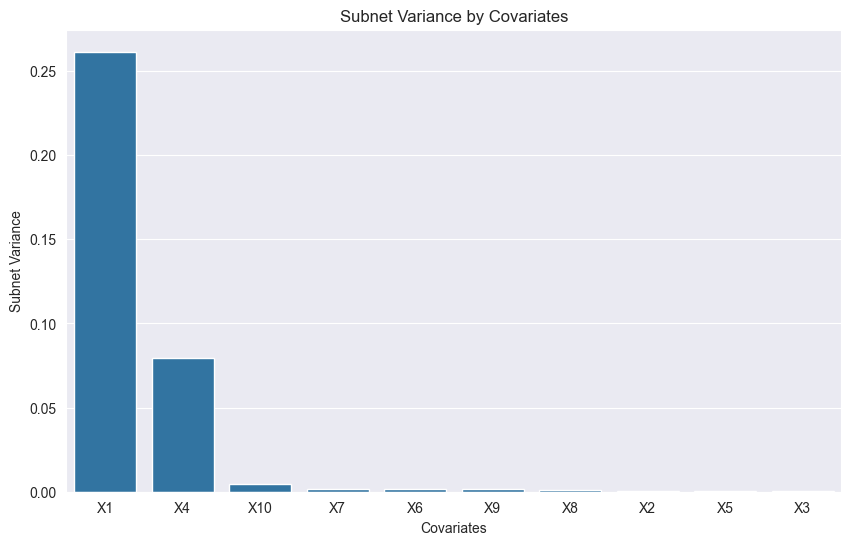

In [911]:
# -------------------------- quantify variable importance --------------------------
main_output_layer = model_main_effect.get_layer("main_subnet")  # Get the subnet output layer
main_model = Model(inputs = model_main_effect.inputs, outputs = main_output_layer.output)
main_output_values = main_model.predict(X_train_split, batch_size = X_train_split[0].shape[0])

# Get the variance of each subnetwork across all data points
subnet_variance = []
for i in range(main_output_values.shape[1]):
    subnet_variance.append(np.var(main_output_values[:, i]))

# Define covariates
covariates = [name for name in all_vars]

# -------------------------- plot the variable importance --------------------------
# Create DataFrame for variable importance
var_importance = pd.DataFrame({"Covariates": covariates, "Subnet Variance": subnet_variance})

# Sort the DataFrame by subnet variance in decreasing order
varimp_sorted = var_importance.sort_values(by = "Subnet Variance", ascending = False)

# Create a bar plot using Seaborn
plt.figure(figsize = (10, 6))
sns.barplot(x = "Covariates", y = "Subnet Variance", data = varimp_sorted)
plt.title("Subnet Variance by Covariates")
plt.xlabel("Covariates")
plt.ylabel("Subnet Variance")
plt.show()

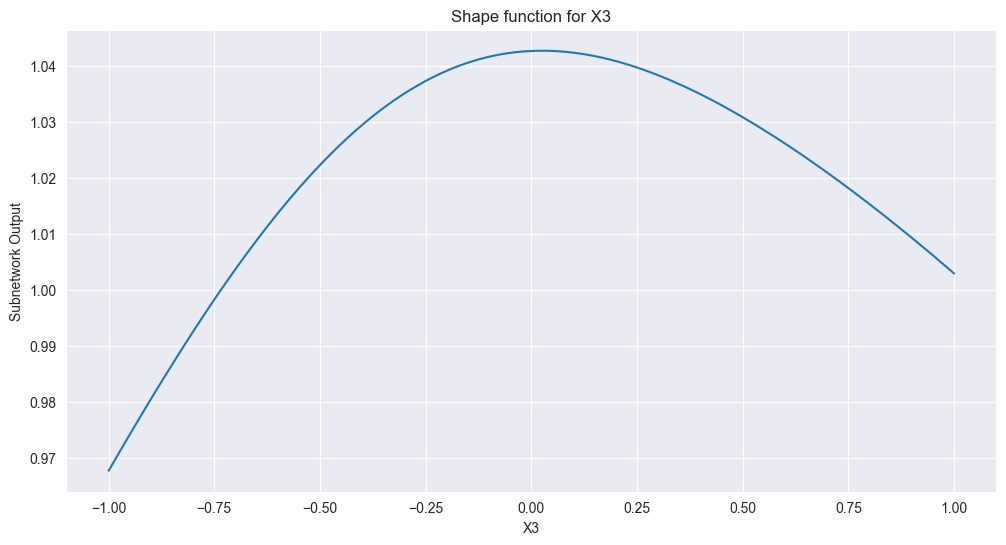

In [912]:
#-------------------------- view the shape function --------------------------
# create the plot
var_name = "X3"
var_index = all_vars.index(var_name)
plt.figure(figsize = (12, 6))
sns.lineplot(x = X_train_split[var_index], 
             y = main_output_values[:,var_index].flatten())
plt.xlabel(f"{var_name}")
plt.ylabel('Subnetwork Output')
plt.title(f"Shape function for {var_name}")
plt.grid(True)
plt.show()

In [913]:
# compile and fit
model_main_effect.compile(optimizer = "rmsprop", 
                          loss = lambda y_true, y_pred: gamma_ll_penalized(y_true, y_pred, model_main_effect, X_train, smooth_vars, lambd = 1), 
                          metrics = [RootMeanSquaredError()])
es = EarlyStopping(restore_best_weights = True, patience = 10)
%time hist_main = model_main_effect.fit(X_train_split, y_train, epochs = 5_000, \
    callbacks = [es], batch_size = 1_000, validation_data = (X_val_split, y_val))

Epoch 1/5000
12/12 [==============================] - 2s 85ms/step - loss: 2830.6689 - root_mean_squared_error: 1812.2792 - val_loss: 2039.8857 - val_root_mean_squared_error: 1808.8018
Epoch 2/5000
12/12 [==============================] - 0s 9ms/step - loss: 1640.4491 - root_mean_squared_error: 1811.7855 - val_loss: 1214.1947 - val_root_mean_squared_error: 1808.0691
Epoch 3/5000
12/12 [==============================] - 0s 9ms/step - loss: 924.3325 - root_mean_squared_error: 1810.9731 - val_loss: 605.2510 - val_root_mean_squared_error: 1807.9546
Epoch 4/5000
12/12 [==============================] - 0s 8ms/step - loss: 420.7107 - root_mean_squared_error: 1810.0771 - val_loss: 265.4206 - val_root_mean_squared_error: 1806.4601
Epoch 5/5000
12/12 [==============================] - 0s 9ms/step - loss: 190.1409 - root_mean_squared_error: 1810.8910 - val_loss: 147.9089 - val_root_mean_squared_error: 1806.9402
Epoch 6/5000
12/12 [==============================] - 0s 8ms/step - loss: 133.9854 - 

1/1 [==============================] - 0s 131ms/step


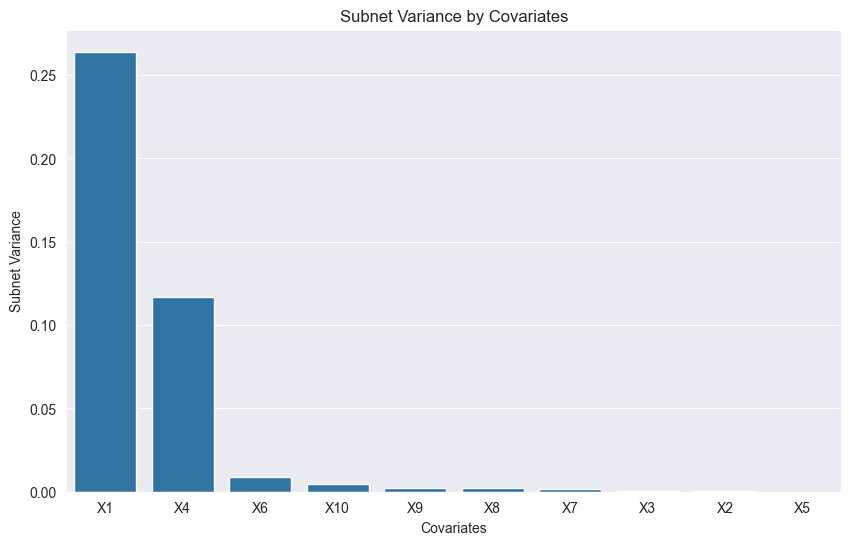

In [914]:
# -------------------------- quantify variable importance --------------------------
main_output_layer = model_main_effect.get_layer("main_subnet")  # Get the subnet output layer
main_model = Model(inputs = model_main_effect.inputs, outputs = main_output_layer.output)
main_output_values = main_model.predict(X_train_split, batch_size = X_train_split[0].shape[0])

# Get the variance of each subnetwork across all data points
subnet_variance = []
for i in range(main_output_values.shape[1]):
    subnet_variance.append(np.var(main_output_values[:, i]))

# Define covariates
covariates = [name for name in all_vars]

# -------------------------- plot the variable importance --------------------------
# Create DataFrame for variable importance
var_importance = pd.DataFrame({"Covariates": covariates, "Subnet Variance": subnet_variance})

# Sort the DataFrame by subnet variance in decreasing order
varimp_sorted = var_importance.sort_values(by = "Subnet Variance", ascending = False)

# Create a bar plot using Seaborn
plt.figure(figsize = (10, 6))
sns.barplot(x = "Covariates", y = "Subnet Variance", data = varimp_sorted)
plt.title("Subnet Variance by Covariates")
plt.xlabel("Covariates")
plt.ylabel("Subnet Variance")
plt.show()

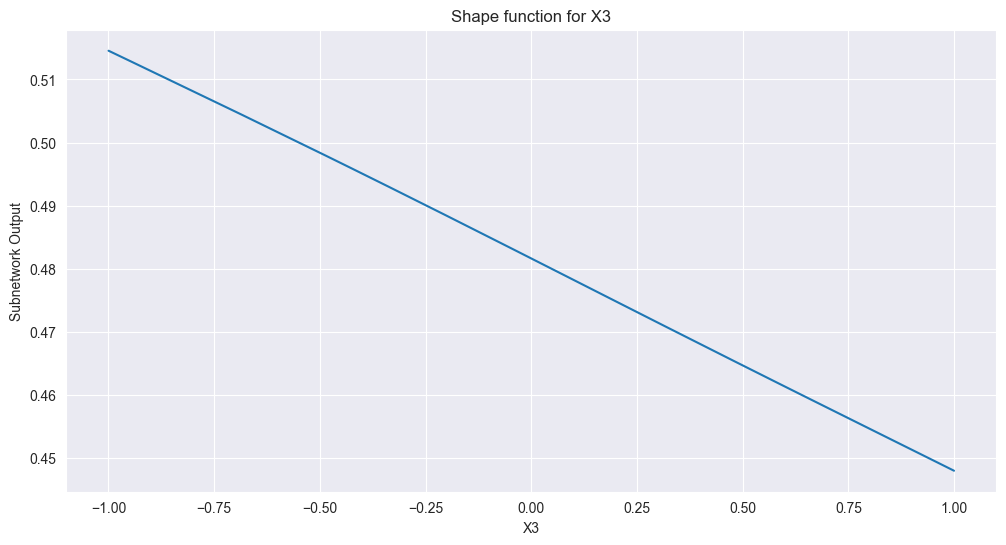

In [915]:
#-------------------------- view the shape function --------------------------
# create the plot
var_name = "X3"
var_index = all_vars.index(var_name)
plt.figure(figsize = (12, 6))
sns.lineplot(x = X_train_split[var_index], 
             y = main_output_values[:,var_index].flatten())
plt.xlabel(f"{var_name}")
plt.ylabel('Subnetwork Output')
plt.title(f"Shape function for {var_name}")
plt.grid(True)
plt.show()